In [69]:
%load_ext autoreload
%autoreload 2

# Sample Diagnostic

Example of a diagnostic showing how the COSIMA cookbook works.

An objective of the COSIMA cookbook is to catalogue useful diagnostics for ocean and ice models.  Certain
tools and patterns are used extensively in these examples.  While the diagnostic itself should be portable
to another framework, there are some conventions used throughout that require explanation.

## Background of a diagnostic notebook

Each diagnostic is written up as a Jupyter notebook with the extension `.ipynb`.  The first cell in the notebook
must be a Markdown cell with a header and a one-line description.  This cell is used by sphinx-nbgallery to collect
all of the diagnostics together the http://cosima-cookbook.readthedocs.io site. 

In this first section, a brief background on the theory of the diagnostic is presented. For this worked example, we will be calculating the eddy kinetic energy (see the Kinetic Energy notebook).  While in real diagnostic notebook, commentary about the diagnostic is presented, here we provide commentary about the technical aspects of how these diagnostics have been implemented.

### A note on names
- The project's long name is "COSIMA Cookbook".
- The GitHub project name is "cosima-cookbook".
- The Python package is called "cosima_cookbook". 

This conventions appears to be consistent with other Python based projects.

### Python import statements

Early in the notebook, there is a code cell that imports all of the needed Python packages.  Internal to cosima_cookbook, other packages may also be important. But, if they are needed in this notebook, they must be
imported explicitly into the namespace.

#### Example of a import cell block

In [1]:
%matplotlib inline

import cosima_cookbook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from tqdm import tqdm_notebook

For static plots, the plotting package matplotlib is used. The inline statement tells Jupyter to place those plots within the notebook file.

It is common to import standard packages with abbreviated package names such as plt, np, pd, and xr. XArray is for
named arrays and can be thought of as layer that sits above the netCDF4 package.

The package tqdm is for progress bars.

These diagnostics are usually very memory and/or computationally expensive.  We leverage the `dask` library http://dask.pydata.org and its related package `distributed` https://distributed.readthedocs.io.

In [2]:
import dask
import distributed

By default, we create a collection of workers -- one work for each core. The memory is set as 70% of the total memory of the node. Beyond that, distributed will start caching results locally.

In [3]:
client = distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:46130 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


You see above that there is a URL for the Dashboard. This is a very useful tool for inspecting the progress of a dask
calculation. If you are running the VDI over VNC you should be able to click on the link to make the dashboard open in another tab.  

If you are running this notebook over a SSH tunnel, you will also have to tunnel the port for the dashboard to your local machine. Here's some code which generates the need string.  Run that command on your local machine. Then the link above should work.  

In [4]:
import os

params = {'host': os.environ['HOSTNAME'],
          'user': os.environ['USER'],
          'port': client.scheduler_info()['services']['bokeh']}

tunnel_cmd = "ssh {host}.nci.org.au -l {user} -L {port}:127.0.0.1:{port}".format(**params)
print(tunnel_cmd)

ssh vdi-n8.nci.org.au -l jm0634 -L 8787:127.0.0.1:8787


### Organization of the model data

By default, all of the model output is assumed to stored in the directory given by

In [5]:
 cosima_cookbook.DataDir

'/g/data3/hh5/tmp/cosima'

This global variable may be changed if needed.



In [6]:
!ls {cosima_cookbook.DataDir}

access-om2-025	bathymetry  mom01v5  mom025  README


The data directory contains several model __configurations__ (mom01v5 or mom025)

In [7]:
!ls {cosima_cookbook.DataDir}/mom01v5

climatology  KDS75	       KDS75_saltfluxes  MOM01_Diagnostics.ipynb
figures      KDS75_PI	       KDS75_UP
GFDL50	     KDS75_salt10days  KDS75_wind


Each configuration contains a number of __experiments__ (KDS75 or KDS75_wind)

In [8]:
!ls {cosima_cookbook.DataDir}/mom01v5/KDS75_salt10days

output266  output272  output278  output284  output290  output296  output302
output267  output273  output279  output285  output291  output297  output303
output268  output274  output280  output286  output292  output298  output304
output269  output275  output281  output287  output293  output299  output305
output270  output276  output282  output288  output294  output300  output306
output271  output277  output283  output289  output295  output301


Which are each made up of a set of several __runs__ (e.g. output266)

In [9]:
!ls {cosima_cookbook.DataDir}/mom01v5/KDS75_salt10days/output266

config.yaml  field_table   logfile.000000.out  ocean_grid.nc   ocean_scalar.nc
data_table   ice_month.nc  mom.err	       ocean_month.nc  overturning.nc
diag_table   input.nml	   mom.out	       ocean.nc        time_stamp.out


The actual model out in stored in NetCDF4 files (denoted by the extention .nc). 

In [10]:
fn = os.path.join(cosima_cookbook.DataDir, 'mom01v5/KDS75_salt10days/output266/ocean.nc')
xr.open_dataset(fn)

<xarray.Dataset>
Dimensions:         (grid_xt_ocean: 3600, grid_yu_ocean: 2700, nv: 2, potrho: 80, potrho_edges: 81, st_edges_ocean: 76, st_ocean: 75, sw_edges_ocean: 76, sw_ocean: 75, time: 1, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * time            (time) object   70-02-15 00:00:00
  * nv              (nv) float64 1.0 2.0
  * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 -80.92 ...
  * st_ocean        (st_ocean) float64 0.5413 1.681 2.94 4.332 5.869 7.569 ...
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 2.279 3.601 5.062 ...
  * grid_xt_ocean   (grid_xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 ...
  * grid_yu_ocean   (grid_yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ...
  * potrho      

There are many, many such NetCDF4 files.

In [11]:
!find {cosima_cookbook.DataDir} -name '*.nc' | wc

  17569   17569 1292984


__Runs__ may change which variables they saved and at what temporal resolution over the course of an __experiment__.  Rather than trying to enumerate the variables _a priori_, we can a data discovery approach using a glob.

In [133]:
directoriesToSearch = ['/g/data3/hh5/tmp/cosima/mom01v5', 
                      ]

In [134]:
%%time
import os
import re
import fnmatch

# search for NetCDF files that reside (perhaps deeply) within
# output* directories
# match the parent and grandparent directory to configuration/experiment
m = re.compile('((.*)/(.*)/(.*)/(output\d+)/(.*\.nc))')

ncfiles = []
for directoryToSearch in directoriesToSearch:
    for root, dirs, filenames in os.walk(directoryToSearch):
        for filename in filenames:
            matched = m.match(os.path.join(root, filename))
            if matched is not None:
                ncfiles.append(matched.groups(0) + (filename,))

CPU times: user 542 ms, sys: 117 ms, total: 659 ms
Wall time: 2.72 s


Build index of all files found directories to search. For 70,000+ files this takes about 1 second.

In [135]:
%%time
import os
files = []
for directoryToSearch in directoriesToSearch:
    for root, dirs, filenames in os.walk(directoryToSearch):
        for filename in filenames:
            files.append(os.path.join(root, filename))

CPU times: user 161 ms, sys: 47 ms, total: 208 ms
Wall time: 1.02 s


In [136]:
import dataset

In [137]:
cosima_cookbook_dir = '/g/data1/v45/cosima-cookbook'
if not os.path.exists(cosima_cookbook_dir):
    os.mkdir(cosima_cookbook_dir)

database_file = '/{}/cosima-cookbook.db'.format(cosima_cookbook_dir)

In [172]:
os.remove(database_file)

In [173]:
db = dataset.connect('sqlite://' + database_file)

In [181]:
list(db['ncfiles'].find(id<3))

TypeError: '<' not supported between instances of 'builtin_function_or_method' and 'int'

In [175]:

files_already_seen = [_ for _ in db['ncfiles'].all()]
print(len(files_already_seen))

0


Files found on disk not seen before:

In [176]:
files_to_add = set(files) - set(files_already_seen)
print(len(files_to_add))

22490


Only add those files that are new

In [177]:
rows_to_insert = [{'filename': fn} for fn in files_to_add]
db['ncfiles'].insert_many(rows_to_insert)

Files seen before but now not found on disk

In [153]:
set(files_already_seen) - set(files)

set()

How many files have been seen before?

In [79]:
for file in table.find():
    print(file)

OrderedDict([('id', 1), ('filename', '/g/data3/hh5/tmp/cosima/README')])
OrderedDict([('id', 2), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/gebco.nc')])
OrderedDict([('id', 3), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/corners.nc')])
OrderedDict([('id', 4), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/kds75.ocean_grid.nc')])
OrderedDict([('id', 5), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/topog_bathy_15-Jun-17.nc')])
OrderedDict([('id', 6), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/ocean_vgrid.nc')])
OrderedDict([('id', 7), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/topog_latest.nc')])
OrderedDict([('id', 8), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/topog_bathy_28-Jun-17.nc')])
OrderedDict([('id', 9), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/load_topo.jnl')])
OrderedDict([('id', 10), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/README')])
OrderedDict([('id', 11), ('filename', '/g/data3/hh5/tmp/cosima/bathymetry/topog_edited_0706

OrderedDict([('id', 608), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/mom.out')])
OrderedDict([('id', 609), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/field_table')])
OrderedDict([('id', 610), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/ocean_grid.nc')])
OrderedDict([('id', 611), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/config.yaml')])
OrderedDict([('id', 612), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/input.nml')])
OrderedDict([('id', 613), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/ice_month.nc')])
OrderedDict([('id', 614), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output090/time_stamp.out')])
OrderedDict([('id', 615), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltund

OrderedDict([('id', 1732), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/ocean_grid.nc')])
OrderedDict([('id', 1733), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/config.yaml')])
OrderedDict([('id', 1734), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/input.nml')])
OrderedDict([('id', 1735), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/ice_month.nc')])
OrderedDict([('id', 1736), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/time_stamp.out')])
OrderedDict([('id', 1737), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/diag_table')])
OrderedDict([('id', 1738), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/overturning.nc')])
OrderedDict([('id', 1739), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf0304/output040/ocean_month.nc')])
OrderedDict([('id', 1740), ('filename', '/g/data3/hh5/t

OrderedDict([('id', 3205), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output049/ice_month.nc')])
OrderedDict([('id', 3206), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output049/time_stamp.out')])
OrderedDict([('id', 3207), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output049/diag_table')])
OrderedDict([('id', 3208), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output049/overturning.nc')])
OrderedDict([('id', 3209), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output049/ocean_month.nc')])
OrderedDict([('id', 3210), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output049/logfile.000000.out')])
OrderedDict([('id', 3211), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output073/data_table')])
OrderedDict([('id', 3212), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091/output073/ocean.nc')])
OrderedDict([('id', 3213), ('filename', '/g/data3/hh

OrderedDict([('id', 4580), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/field_table')])
OrderedDict([('id', 4581), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/ocean_grid.nc')])
OrderedDict([('id', 4582), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/config.yaml')])
OrderedDict([('id', 4583), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/input.nml')])
OrderedDict([('id', 4584), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/ice_month.nc')])
OrderedDict([('id', 4585), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/time_stamp.out')])
OrderedDict([('id', 4586), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/diag_table')])
OrderedDict([('id', 4587), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output068/overturning.nc')])
OrderedDict([('id', 4588), ('filename', '/g/data3/hh5/tmp/

OrderedDict([('id', 5744), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output060/logfile.000000.out')])
OrderedDict([('id', 5745), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/data_table')])
OrderedDict([('id', 5746), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/ocean.nc')])
OrderedDict([('id', 5747), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/ocean_scalar.nc')])
OrderedDict([('id', 5748), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/mom.err')])
OrderedDict([('id', 5749), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/mom.out')])
OrderedDict([('id', 5750), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/field_table')])
OrderedDict([('id', 5751), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf8485/output044/ocean_grid.nc')])
OrderedDict([('id', 5752), ('filename', '/g/data3/hh5/tmp/cosim

OrderedDict([('id', 7249), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output060/logfile.000000.out')])
OrderedDict([('id', 7250), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/data_table')])
OrderedDict([('id', 7251), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/ocean.nc')])
OrderedDict([('id', 7252), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/ocean_scalar.nc')])
OrderedDict([('id', 7253), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/mom.err')])
OrderedDict([('id', 7254), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/mom.out')])
OrderedDict([('id', 7255), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/field_table')])
OrderedDict([('id', 7256), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/ocean_grid.nc')])
OrderedDict([('id', 7257), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output044/config.yaml')])
OrderedDict([('id'

OrderedDict([('id', 8718), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output012/ocean_month.nc')])
OrderedDict([('id', 8719), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output012/logfile.000000.out')])
OrderedDict([('id', 8720), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output072/data_table')])
OrderedDict([('id', 8721), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output072/ocean.nc')])
OrderedDict([('id', 8722), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output072/ocean_scalar.nc')])
OrderedDict([('id', 8723), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output072/mom.err')])
OrderedDict([('id', 8724), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output072/mom.out')])
OrderedDict([('id', 8725), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output072/field_table')])
OrderedDict([('id', 8726), ('filename', '/g/data3/hh5/tmp/cosima/mom025/mom025_nyf_sal

OrderedDict([('id', 9999), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output319/logfile.000000.out')])
OrderedDict([('id', 10000), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/data_table')])
OrderedDict([('id', 10001), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/ocean.nc')])
OrderedDict([('id', 10002), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/ocean_scalar.nc')])
OrderedDict([('id', 10003), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/mom.err')])
OrderedDict([('id', 10004), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/mom.out')])
OrderedDict([('id', 10005), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/field_table')])
OrderedDict([('id', 10006), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/ocean_grid.nc')])
OrderedDict([('id', 10007), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75_UP/output336/config.yaml')])
OrderedDict([('id',

OrderedDict([('id', 11252), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean_month.nc.0054')])
OrderedDict([('id', 11253), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean.nc.0349')])
OrderedDict([('id', 11254), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ice_month.nc.0325')])
OrderedDict([('id', 11255), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean_grid.nc.0069')])
OrderedDict([('id', 11256), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean_month.nc.0132')])
OrderedDict([('id', 11257), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean.nc.0107')])
OrderedDict([('id', 11258), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ice_month.nc.0157')])
OrderedDict([('id', 11259), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean_grid.nc.0261')])
OrderedDict([('id', 11260), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output357/ocean_m

OrderedDict([('id', 12718), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output336/ocean_month.nc')])
OrderedDict([('id', 12719), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output336/logfile.000000.out')])
OrderedDict([('id', 12720), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/data_table')])
OrderedDict([('id', 12721), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/ocean.nc')])
OrderedDict([('id', 12722), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/ocean_scalar.nc')])
OrderedDict([('id', 12723), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/mom.err')])
OrderedDict([('id', 12724), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/mom.out')])
OrderedDict([('id', 12725), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/field_table')])
OrderedDict([('id', 12726), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output371/ocean_grid.nc')])
OrderedDict([('id', 12727), ('fil

OrderedDict([('id', 14204), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_308.nc')])
OrderedDict([('id', 14205), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_303.nc')])
OrderedDict([('id', 14206), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_311.nc')])
OrderedDict([('id', 14207), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/mom.out')])
OrderedDict([('id', 14208), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_304.nc')])
OrderedDict([('id', 14209), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_355.nc')])
OrderedDict([('id', 14210), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_315.nc')])
OrderedDict([('id', 14211), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output395/rregionoceankerg__0072_360.nc')])
OrderedDict([('id', 14

OrderedDict([('id', 15592), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333/input.nml')])
OrderedDict([('id', 15593), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333/ice_month.nc')])
OrderedDict([('id', 15594), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333/time_stamp.out')])
OrderedDict([('id', 15595), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333/diag_table')])
OrderedDict([('id', 15596), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333/ocean_month.nc')])
OrderedDict([('id', 15597), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333/logfile.000000.out')])
OrderedDict([('id', 15598), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output407/data_table')])
OrderedDict([('id', 15599), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output407/ocean.nc')])
OrderedDict([('id', 15600), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output407/ocean_scalar.nc')])
OrderedDict([('id', 15601)

OrderedDict([('id', 16910), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/ocean.nc')])
OrderedDict([('id', 16911), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/ocean_scalar.nc')])
OrderedDict([('id', 16912), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/mom.err')])
OrderedDict([('id', 16913), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/mom.out')])
OrderedDict([('id', 16914), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/field_table')])
OrderedDict([('id', 16915), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/ocean_grid.nc')])
OrderedDict([('id', 16916), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/config.yaml')])
OrderedDict([('id', 16917), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/input.nml')])
OrderedDict([('id', 16918), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output232/ice_month.nc')])
OrderedDict([('id', 16919), ('filename', '/g/data3/h

OrderedDict([('id', 18259), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_209.nc')])
OrderedDict([('id', 18260), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_213.nc')])
OrderedDict([('id', 18261), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_210.nc')])
OrderedDict([('id', 18262), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_189.nc')])
OrderedDict([('id', 18263), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/mom.err')])
OrderedDict([('id', 18264), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_218.nc')])
OrderedDict([('id', 18265), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_252.nc')])
OrderedDict([('id', 18266), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output108/rregionoceankerg__0030_202.nc')])
OrderedDict([('id', 18267), ('

OrderedDict([('id', 19746), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/rregionoceankerg__0041_148.nc')])
OrderedDict([('id', 19747), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/time_stamp.out')])
OrderedDict([('id', 19748), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/diag_table')])
OrderedDict([('id', 19749), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/rregionoceankerg__0041_178.nc')])
OrderedDict([('id', 19750), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/rregionoceankerg__0041_138.nc')])
OrderedDict([('id', 19751), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/overturning.nc')])
OrderedDict([('id', 19752), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/rregionoceankerg__0041_128.nc')])
OrderedDict([('id', 19753), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output151/rregionoceankerg__0041_103.nc')])
OrderedDict([('id', 19754), ('filename', '/g/data3/hh5/tm

OrderedDict([('id', 20675), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_326.nc')])
OrderedDict([('id', 20676), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_284.nc')])
OrderedDict([('id', 20677), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_327.nc')])
OrderedDict([('id', 20678), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_319.nc')])
OrderedDict([('id', 20679), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_278.nc')])
OrderedDict([('id', 20680), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_355.nc')])
OrderedDict([('id', 20681), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_348.nc')])
OrderedDict([('id', 20682), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output093/rregionoceankerg__0026_281.nc')])
OrderedD

OrderedDict([('id', 21630), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output260/overturning.nc')])
OrderedDict([('id', 21631), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output260/ocean_month.nc')])
OrderedDict([('id', 21632), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output260/logfile.000000.out')])
OrderedDict([('id', 21633), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output152/rregionoceankerg__0041_184.nc')])
OrderedDict([('id', 21634), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output152/rregionoceankerg__0041_244.nc')])
OrderedDict([('id', 21635), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output152/data_table')])
OrderedDict([('id', 21636), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output152/ocean.nc')])
OrderedDict([('id', 21637), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output152/ocean_scalar.nc')])
OrderedDict([('id', 21638), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output152/rregionoceank

OrderedDict([('id', 21816), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_053.nc')])
OrderedDict([('id', 21817), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_062.nc')])
OrderedDict([('id', 21818), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_061.nc')])
OrderedDict([('id', 21819), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_045.nc')])
OrderedDict([('id', 21820), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_007.nc')])
OrderedDict([('id', 21821), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_075.nc')])
OrderedDict([('id', 21822), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_025.nc')])
OrderedDict([('id', 21823), ('filename', '/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output090/rregionoceankerg__0026_011.nc')])
OrderedD

KeyboardInterrupt: 

Persist this file list

In [75]:

table.insert_many(files)

In [76]:
table.count()

71053

Notice that, unlike the find command above, the glob has only identified .nc files that with in the
__configuration__/__experiment__/__run__ directory structure.

We want to produce an index over all of these NetCDF files. Once we do that, we can build our diagnostics by first
querying that index.

In [15]:
rows = [cosima_cookbook.index_ncfile(fn[0]) for fn in ncfiles[:15]]

index_ncfile() returns a list of dictionaries describing each variable in an the NetCDF file. 

In [16]:
rows[0][:3]

[{'chunking': (1440,),
  'configuration': '',
  'dimensions': ('xt_ocean',),
  'experiment': 'mom025/mom025_jra_ryf9091_saltunderice',
  'name': 'xt_ocean',
  'ncfile': 'ocean.nc',
  'ncpath': '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output076/ocean.nc',
  'run': ''},
 {'chunking': (1080,),
  'configuration': '',
  'dimensions': ('yt_ocean',),
  'experiment': 'mom025/mom025_jra_ryf9091_saltunderice',
  'name': 'yt_ocean',
  'ncfile': 'ocean.nc',
  'ncpath': '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output076/ocean.nc',
  'run': ''},
 {'chunking': (50,),
  'configuration': '',
  'dimensions': ('st_ocean',),
  'experiment': 'mom025/mom025_jra_ryf9091_saltunderice',
  'name': 'st_ocean',
  'ncfile': 'ocean.nc',
  'ncpath': '/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9091_saltunderice/output076/ocean.nc',
  'run': ''}]

The list comprehension gives back a list of lists.  To continue, we first flatten this list of lists:

In [17]:
rows = [item for sublist in rows for item in sublist]

Finally, we can convert this dictionary 

In [18]:
df = pd.DataFrame(rows)

In [19]:
df

,chunking,configuration,dimensions,experiment,name,ncfile,ncpath,run
0,"(1440,)",,"(xt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
1,"(1080,)",,"(yt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
2,"(50,)",,"(st_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
3,"(51,)",,"(st_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
4,"(1,)",,"(time,)",mom025/mom025_jra_ryf9091_saltunderice,time,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
5,"(2,)",,"(nv,)",mom025/mom025_jra_ryf9091_saltunderice,nv,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
6,"(1440,)",,"(xu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
7,"(1080,)",,"(yu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
8,"(50,)",,"(sw_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
9,"(51,)",,"(sw_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,


So this gives us a nice index for all variables over all NetCDF files.  However, since we have tens of thousands of ncfiles, generating this index can be slow.  To improve performance, we can use a dask bag.

In [34]:
bag = dask.bag.from_sequence([_[0] for _ in ncfiles],npartitions=1000)
rows = bag.map(cosima_cookbook.index_ncfile)

In [35]:
futures = client.compute(rows)

In [38]:
futures

<Future: status: error, key: finalize-75b876d2ab32a25d28759ff2ab75ab04>

In [52]:
import dataset

In [50]:
futures.cancelled()

False

In [32]:
from distributed.diagnostics.progressbar import progress

In [46]:
progress(futures)

To actually get the computation to occur, we can conver the bag into a list.  This takes a few minutes.

In [20]:
%%time
rows = list(rows)

CPU times: user 4.24 s, sys: 772 ms, total: 5.01 s
Wall time: 41 s


As before, we convert the list of lists to a single list

In [21]:
rows = [item for sublist in rows for item in sublist]

Finally, we can put this all into a pandas DataFrame

In [22]:
df = pd.DataFrame.from_records(rows)

In [23]:
df

,chunking,configuration,dimensions,experiment,name,ncfile,ncpath,run
0,"(1440,)",,"(xt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
1,"(1080,)",,"(yt_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yt_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
2,"(50,)",,"(st_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
3,"(51,)",,"(st_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,st_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
4,"(1,)",,"(time,)",mom025/mom025_jra_ryf9091_saltunderice,time,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
5,"(2,)",,"(nv,)",mom025/mom025_jra_ryf9091_saltunderice,nv,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
6,"(1440,)",,"(xu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,xu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
7,"(1080,)",,"(yu_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,yu_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
8,"(50,)",,"(sw_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,
9,"(51,)",,"(sw_edges_ocean,)",mom025/mom025_jra_ryf9091_saltunderice,sw_edges_ocean,ocean.nc,/g/data3/hh5/tmp/cosima/mom025/mom025_jra_ryf9...,


The above steps are implemented in

In [28]:
df = cosima_cookbook.build_index()

Here are all of the unique experiments found in the data

In [40]:
expts = df.experiment.unique()
expts

array(['mom01v5/GFDL50', 'mom01v5/KDS75', 'mom01v5/KDS75_PI',
       'mom01v5/KDS75_UP', 'mom01v5/KDS75_salt10days',
       'mom01v5/KDS75_saltfluxes', 'mom01v5/KDS75_wind',
       'mom025/mom025_jra_ryf0304', 'mom025/mom025_jra_ryf8485',
       'mom025/mom025_jra_ryf9091',
       'mom025/mom025_jra_ryf9091_saltunderice', 'mom025/mom025_nyf',
       'mom025/mom025_nyf_salt'], dtype=object)

In [43]:
expts[7]

'mom025/mom025_jra_ryf0304'

In [49]:
list(df)

['chunking',
 'configuration',
 'dimensions',
 'experiment',
 'name',
 'ncfile',
 'ncpath',
 'run']

## Calculation of EKE

Let's choose a specific experiment:

In [45]:
expt = expts[1]
expt

'mom01v5/KDS75'

To calculate the eddy kinetic energy, we are going to consider only  portions of simulations which have 5-day average velocities saved, which means directories with `ocean__*.nc` files.

Using our index of ncfiles, we search for such nc files.

In [55]:
u = cosima_cookbook.get_nc_variable(expt, 'ocean__', 'u', n=6)

OSError: [Errno 24] Too many open files: '/local/v45/jm0634/tmp/joblib/cosima_cookbook/build_index/func_code.py'

In [31]:
@cosima_cookbook.memory.cache
def calc_eke(expt, box_index):
    yi, xi = box_index
   
    box = {'yu_ocean': slice(300*yi, 300*(yi+1)),
           'xu_ocean': slice(400*xi, 400*(xi+1))}
    
    op = lambda p: p.isel(**box)

    u = get_nc_variable(expt, 'ocean__', 'u', op=op, n=72)
    v = get_nc_variable(expt, 'ocean__', 'v', op=op, n=72)
    
    u_avg = u.mean('time')
    v_avg = v.mean('time')

    MKE = 0.5 * (u_avg**2 + v_avg**2)
    MKE = MKE.sum(dim='st_ocean')
    MKE = MKE.to_dataset(name='MKE')
    
    u_ = u - u_avg
    v_ = v - v_avg
    
    EKE = 0.5 * (u_**2 + v_**2)

    EKE = EKE.sum(dim='st_ocean')
    EKE = EKE.to_dataset(name='EKE')

    dsx = xr.merge([MKE, EKE])
    dsx.load()
        
    return dsx

In [32]:
from itertools import product

# ceil(x/y) = (x+y+1)//y
yi = range(2700//(300)) 
xi = range(3600//(400))

box_indexes = list(product(*[yi, xi]))

### Maps

In [ ]:
from mpl_toolkits.basemap import Basemap, shiftgrid

mom01v5/KDS75


/short/v45/jm0634/conda/envs/cosima/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


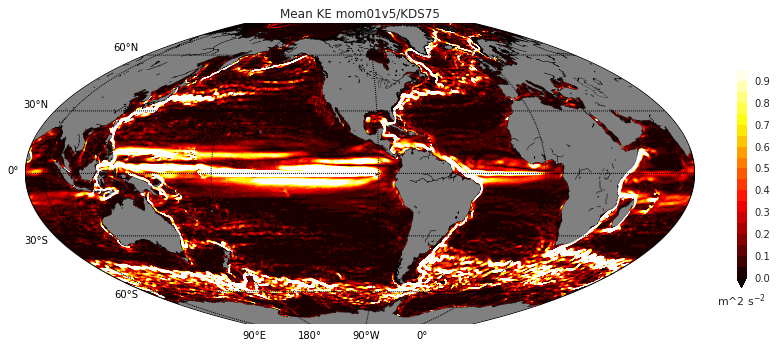

In [15]:
expt = expts[1]

print(expt)
# Plot in basemap 

plt.figure(figsize=(15,6))
lev = np.arange(0, 1.0, 0.05)
map = Basemap(projection='mbtfpq',
              lon_0 = -100, resolution='l')
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
map.drawparallels(np.arange(-60.,61.,30.),
                  labels=[True,False,False,False])
map.drawmeridians(np.arange(-180.,181.,90.),
                  labels=[False,False,False,True])

for box_index in tqdm_notebook(box_indexes):
    #print(box_index)
    dsx = calc_eke(expt, box_index)
    
    x=dsx.xu_ocean[:]
    y=dsx.yu_ocean[:]
    lon, lat = np.meshgrid(x, y)
    
    X, Y = map(lon,lat) 
    
    map.contourf(X, Y, dsx.MKE,
                 cmap=plt.cm.hot,
                 levels=lev,extend='both')

cb = plt.colorbar(orientation='vertical',shrink = 0.7)

cb.ax.set_xlabel('m^2 s$^{-2}$')
plt.title('Mean KE {}'.format(expt))

### Readthedocs website

The diagnostic webpages are generated automatically using Sphinx http://www.sphinx-doc.org and using a Sphinx extention called http://sphinx-nbexamples.readthedocs.io

The readthedocs site is automatically regenerated when every a commit is made to the repository on GitHub.